In [37]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torchvision.datasets.folder import default_loader
import torch.nn.init as init

import torchvision

import math
import matplotlib.pyplot as plt

import os

import numpy as np

# Transformando nossos .jpg em tensores que vão virar nosso conjunto de treino :

In [4]:
# Caminho para a pasta com as imagens
path = "/Users/matheus/Documents/faculdade/Intro. ML/Trabalho Final - ML/database"

# Transformações para aplicar às imagens
transform = transforms.Compose([
    # transforms.Resize((128, 128)),  # Redimensiona as imagens para 128x128 pixels
    transforms.ToTensor(), # Converte as imagens em tensores
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normaliza os valores de pixel

])

files_list = os.listdir(path)
train_data_length = len(files_list)

# criando os tensores para armazenar as imagens e rótulos
train_data = torch.zeros(train_data_length, 3, 128, 128) # 3 canais de cores, 128x128 pixels
train_labels = torch.zeros(train_data_length)

# Percorre os arquivos na pasta de imagens
for filename in os.listdir(path):  # os.listdir(data_folder) retorna uma lista com todos arquivos que estão no path 
    if filename.endswith(".jpg"):
        # Carrega a imagem usando o loader padrão
        img_path = os.path.join(path, filename)
        img = default_loader(img_path)

        # Aplica as transformações à imagem
        img = transform(img)

        # Salva a imagem no tensor train_data
        index = files_list.index(filename)
        train_data[index] = img

train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

# Cria um DataLoader para carregar os dados em lotes durante o treinamento
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=32, shuffle=True
    )


In [ ]:
# preparando terreno para usarmos GPU quando possível (se não, usaremos CPU)
#device = ""
#if torch.cuda.is_available():
#    device = torch.device("cuda")
#else:
#    device = torch.device("cpu")

# no caso do mac ( meu caso, o device vai ser mps se estiver disponível, se não, cpu)
print(f"PyTorch version: {torch.__version__}")

# Checa se PyTorch tem acesso ao MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Seta o device      
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

PyTorch version: 2.0.1
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


# Aqui estão exemplos de imagens que estão no nosso train_set :

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

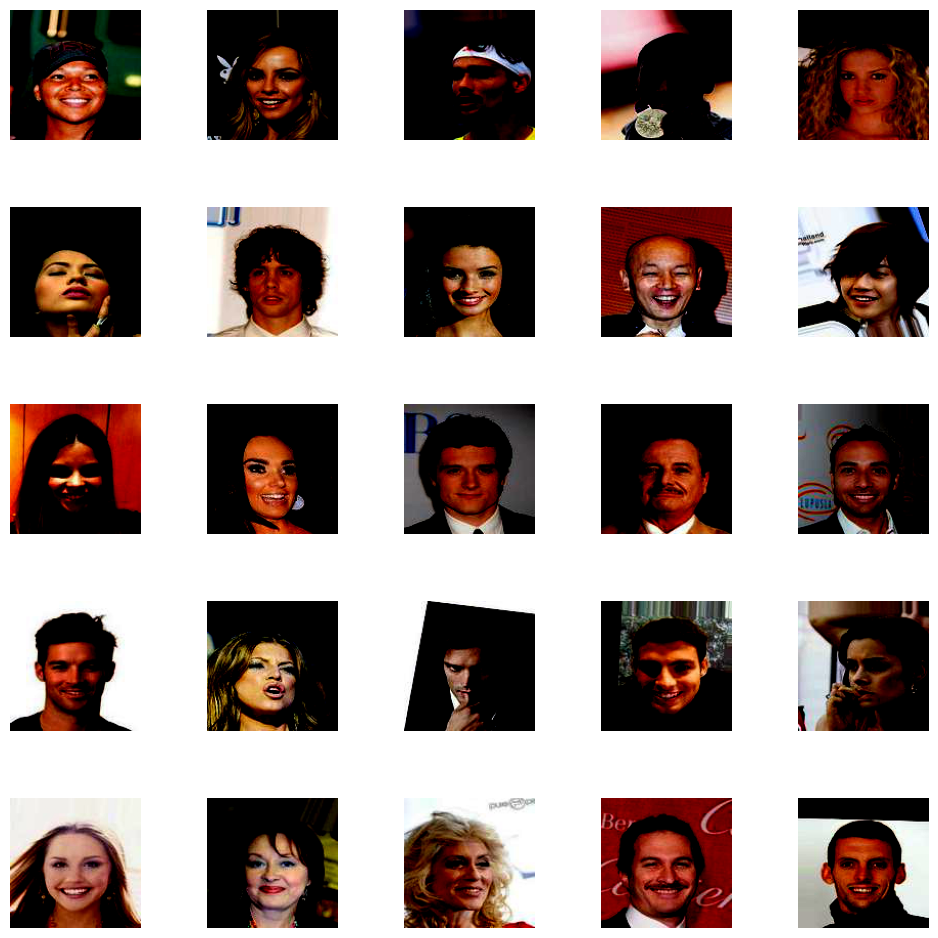

In [6]:
real_samples, labels = next(iter(train_loader))

n = 5
# Exibir as imagens
fig, axs = plt.subplots(n, n, figsize=(10, 10))
fig.tight_layout()

for i in range(n**2):
    row = i // n
    col = i % n
    img = real_samples[i].permute(1, 2, 0)  # Reorganizar as dimensões do tensor
    axs[row, col].imshow(img)
    axs[row, col].axis("off")

plt.show()

# Criando as classes que representam as redes Generativas e Discriminativas

# Tentativa Número 1 , rede neural ingênua com ativações das camadas majoritariamente usando ReLU e na saída do discriminador utilizamos sigmoide, uma vez que queremos valores entre 0 e 1 para determinar a probabilidade de aquilo sendo descriminado estar vindo de uma rede generativa ou de uma outra base de dados qualquer  

In [33]:
dimensao = 128
numero_de_pixels = dimensao * dimensao

#help
class Discriminator(nn.Module):
    """
    Implementa o discriminador da rede GAN que herda da classe nn.Module que tem já implementado algumas funcionalidades convencionais.
    Rede neural com camada inicial de tamanho 3*128*128 ( canais de entrada de cor * dimensão * dimensão ) e camada final de tamanho 1
    ( saída binária ) com função de ativação sigmoid.
    
    """
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3 * 128 * 128, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x) -> torch.Tensor:
        x = x.view(x.size(0), 3 * 128 * 128)
        output = self.model(x)
        return output
    

discriminator = Discriminator().to(device=device)

In [34]:
class Generator(nn.Module):
    """
    Implementa o gerador da rede GAN que herda da classe nn.Module que tem já implementado algumas funcionalidades convencionais.
    Rede neural com camada inicial de tamanho 100 ( tamanho do vetor de entrada ) e camada final de tamanho 3*128*128 
    ( canais de saída de cor * dimensão * dimensão )

    """

    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 3 * 128 * 128),
            nn.Tanh(),
        )

    def forward(self, x) -> torch.Tensor:
        output = self.model(x)
        output = output.view(x.size(0), 3, 128, 128)
        return output

generator = Generator().to(device=device)

In [35]:
lr = 0.0001 # learning rating 
num_epochs = 50 # número de épocas ( iterações )
loss_function = nn.BCELoss() # função de perda ( binary cross entropy loss )

# Otimizadores para o gerador e o discriminador, seguindo o algoritmo Adam
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [42]:
import os
from PIL import Image

# Defina o diretório onde as imagens geradas serão salvas
output_dir = 'outputsTentativa1'

# Verifique se o diretório de saída existe, caso contrário, crie-o
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        real_samples = real_samples.to(device=device)
        batch_size = real_samples.shape[0]  # Obter o tamanho atual do lote
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
        generated_samples = generator(latent_space_samples)
        all_samples = torch.cat((real_samples, generated_samples))

        # Treinamento do discriminador
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        real_samples_labels = torch.ones((batch_size, 1)).to(device=device)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Dados para o treinamento do gerador
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)

        # Treinamento do gerador
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Exibir as perdas
        if n == len(train_loader) - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

    # Gerar imagens a cada 10 épocas
    if (epoch + 1) % 10 == 0:
        # Criar uma pasta para a época atual
        epoch_dir = os.path.join(output_dir, f"epoch_{epoch + 1}")
        if not os.path.exists(epoch_dir):
            os.makedirs(epoch_dir)

        # Gerar e salvar as imagens
        with torch.no_grad():
            latent_space_samples = torch.randn((10, 100)).to(device=device)
            generated_samples = generator(latent_space_samples).detach().cpu()

        for i in range(10):
            image = generated_samples[i].permute(1, 2, 0)
            image = (image + 1) / 2
            image = image.clamp(0, 1)  # Garantir que os valores estejam entre 0 e 1
            image = np.array(image.detach().cpu())  # Converter para numpy array
            image = np.uint8(image * 255)  # Converter para valores inteiros entre 0 e 255
            save_path = os.path.join(epoch_dir, f"sample_{i + 1}.png")
            image = Image.fromarray(image)
            image.save(save_path)

Epoch: 0 Loss D.: 0.14343492686748505
Epoch: 0 Loss G.: 2.9345908164978027
Epoch: 1 Loss D.: 0.13780367374420166
Epoch: 1 Loss G.: 3.5550639629364014
Epoch: 2 Loss D.: 0.33347195386886597
Epoch: 2 Loss G.: 3.1781702041625977
Epoch: 3 Loss D.: 0.2509017884731293
Epoch: 3 Loss G.: 3.2687854766845703
Epoch: 4 Loss D.: 0.30953502655029297
Epoch: 4 Loss G.: 3.0743393898010254
Epoch: 5 Loss D.: 0.211490198969841
Epoch: 5 Loss G.: 3.233539342880249
Epoch: 6 Loss D.: 0.5526471734046936
Epoch: 6 Loss G.: 2.643550395965576
Epoch: 7 Loss D.: 0.22826993465423584
Epoch: 7 Loss G.: 2.5732438564300537
Epoch: 8 Loss D.: 0.290617436170578
Epoch: 8 Loss G.: 2.781053066253662
Epoch: 9 Loss D.: 0.2504388093948364
Epoch: 9 Loss G.: 2.712191343307495
Epoch: 10 Loss D.: 0.20592036843299866
Epoch: 10 Loss G.: 3.046053886413574


# Agora iremos fazer nossa tentativa 2 e adicionar algumas mudanças, pesquisamos a fundo e descobrimos que leakyReLU pode ter um resultado melhor no nosso código, então vamos mudar nossas funções de ativação, e outra técnica mais avançada que costumam usar é criar ciclos para o discriminador agir, ele só vai criticar de k em k épocas, então farei isso, vou incluir essa técnica no nosso modelo

In [ ]:
dimensao = 128
numero_de_pixels = dimensao * dimensao

#help
class Discriminator(nn.Module):
    """
    Implementa o discriminador da rede GAN que herda da classe nn.Module que tem já implementado algumas funcionalidades convencionais.
    Rede neural com camada inicial de tamanho 3*128*128 ( canais de entrada de cor * dimensão * dimensão ) e camada final de tamanho 1
    ( saída binária ) com função de ativação sigmoid.

    """
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3 * 128 * 128, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x) -> torch.Tensor:
        x = x.view(x.size(0), 3 * 128 * 128)
        output = self.model(x)
        return output


discriminator = Discriminator().to(device=device)

In [ ]:
class Generator(nn.Module):
    """
    Implementa o gerador da rede GAN que herda da classe nn.Module que tem já implementado algumas funcionalidades convencionais.
    Rede neural com camada inicial de tamanho 100 ( tamanho do vetor de entrada ) e camada final de tamanho 3*128*128 
    ( canais de saída de cor * dimensão * dimensão )

    """

    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 3 * 128 * 128),
            nn.Tanh(),
        )

    def forward(self, x) -> torch.Tensor:
        output = self.model(x)
        output = output.view(x.size(0), 3, 128, 128)
        return output

generator = Generator().to(device=device)

# Escolhendo os parâmetros de treinamento

In [ ]:
lr = 0.0001  # Learning rate
num_epochs = 50 # Número de épocas
loss_function = nn.BCELoss()  # Função de perda (Binary Cross Entropy Loss)

# Otimizadores para o gerador e o discriminador, seguindo o algoritmo Adam
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))


In [ ]:
k = 5  # Atualizar o discriminador a cada 5 épocas
num_discriminator_updates = 0  # Contador para controlar a atualização do discriminador

for epoch in range(num_epochs):
    update_discriminator = False  # Variável para controlar a atualização do discriminador

    for n, (real_samples, _) in enumerate(train_loader):
        real_samples = real_samples.to(device=device)
        batch_size = real_samples.shape[0]  # Obter o tamanho atual do lote
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
        generated_samples = generator(latent_space_samples)
        all_samples = torch.cat((real_samples, generated_samples))

        # Verificar se o discriminador deve ser atualizado nesta iteração
        if num_discriminator_updates >= k:
            update_discriminator = True
            num_discriminator_updates = 0
        else:
            update_discriminator = False

        if update_discriminator:
            # Treinamento do discriminador
            discriminator.zero_grad()
            output_discriminator = discriminator(all_samples)
            real_samples_labels = torch.ones((batch_size, 1)).to(device=device)
            generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)
            all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))
            loss_discriminator = loss_function(output_discriminator, all_samples_labels)
            loss_discriminator.backward()
            optimizer_discriminator.step()

        # Dados para o treinamento do gerador
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)

        # Treinamento do gerador
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Exibir as perdas
        if n == len(train_loader) - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

        # Atualizar o contador num_discriminator_updates
        num_discriminator_updates += 1
        
        # Gerar imagens a cada 10 épocas
        if (epoch + 1) % 10 == 0:
            # Criar uma pasta para a época atual
            epoch_dir = os.path.join(output_dir, f"epoch_{epoch + 1}")
            if not os.path.exists(epoch_dir):
                os.makedirs(epoch_dir)

            # Gerar e salvar as imagens
            with torch.no_grad():
                latent_space_samples = torch.randn((10, 100)).to(device=device)
                generated_samples = generator(latent_space_samples).detach().cpu()

            for i in range(10):
                image = generated_samples[i].permute(1, 2, 0)
                image = (image + 1) / 2
                save_path = os.path.join(epoch_dir, f"sample_{i + 1}.png")
                torchvision.utils.save_image(image, save_path)

Epoch: 0 Loss D.: 0.3894726634025574
Epoch: 0 Loss G.: 1.6373662948608398
Epoch: 1 Loss D.: 0.15936705470085144
Epoch: 1 Loss G.: 2.212900400161743
Epoch: 2 Loss D.: 0.332004189491272
Epoch: 2 Loss G.: 1.7341210842132568
Epoch: 3 Loss D.: 0.4556998610496521
Epoch: 3 Loss G.: 2.9216322898864746
Epoch: 4 Loss D.: 0.18617479503154755
Epoch: 4 Loss G.: 3.1383872032165527
Epoch: 5 Loss D.: 0.01550857163965702
Epoch: 5 Loss G.: 4.606349468231201
Epoch: 6 Loss D.: 0.12625867128372192
Epoch: 6 Loss G.: 2.928786039352417
Epoch: 7 Loss D.: 0.0702962726354599
Epoch: 7 Loss G.: 3.8826212882995605
Epoch: 8 Loss D.: 0.009294266812503338
Epoch: 8 Loss G.: 5.514770030975342
Epoch: 9 Loss D.: 0.030754487961530685
Epoch: 9 Loss G.: 4.256072998046875
Epoch: 10 Loss D.: 0.0508543960750103
Epoch: 10 Loss G.: 4.152559280395508
Epoch: 11 Loss D.: 0.157027006149292
Epoch: 11 Loss G.: 4.752920150756836
Epoch: 12 Loss D.: 0.024782944470643997
Epoch: 12 Loss G.: 4.437847137451172
Epoch: 13 Loss D.: 0.21488973498

In [ ]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 1, kernel_size=4, stride=2, padding=1)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = nn.functional.leaky_relu(self.conv1(x), 0.2)
        x = nn.functional.leaky_relu(self.conv2(x), 0.2)
        x = nn.functional.leaky_relu(self.conv3(x), 0.2)
        x = self.activation(self.conv4(x))
        return x

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.deconv1 = nn.ConvTranspose2d(100, 256, kernel_size=4, stride=1, padding=0)
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = nn.functional.relu(self.deconv1(x))
        x = nn.functional.relu(self.deconv2(x))
        x = nn.functional.relu(self.deconv3(x))
        x = self.activation(self.deconv4(x))
        return x
